In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

# dickey fuller test for stationarity check
from statsmodels.tsa.stattools import adfuller,acf,pacf

#ARMA/ARIMA
from statsmodels.tsa.arima.model import ARIMA

#Ljung-Box-Test
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
#plot acf and pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
#sarima/sarimax lib
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv("ppi.csv",index_col="yearqrt",parse_dates=True)
data.head(10)

,m3,ppi,cpi,gdp,m1nsa,ddnsa,t,lnppi,dppi,dlnppi,lppi,trend
yearqrt,,,,,,,,,,,,
1960-01-01,692.00000,25.400000,19.280001,2391.0000,140.53000,111.67,1960q2,3.234749,NaN,NaN,NaN,1
1960-04-01,701.59998,25.440001,19.400000,2379.2000,138.42999,109.47,1960q3,3.236323,0.040001,0.001574,25.400000,2
1960-07-01,709.50000,25.370001,19.450001,2383.6001,139.60001,110.33,1960q4,3.233567,-0.070000,-0.002755,25.440001,3
1960-10-01,722.09998,25.400000,19.559999,2352.8999,142.67999,113.23,1961q1,3.234749,0.029999,0.001182,25.370001,4
1961-01-01,726.20001,25.490000,19.570000,2366.5000,142.22000,113.40,1961q2,3.238286,0.090000,0.003537,25.400000,5
1961-04-01,735.29999,25.240000,19.580000,2410.8000,141.36000,112.48,1961q3,3.228430,-0.250000,-0.009856,25.490000,6
1961-07-01,748.20001,25.240000,19.680000,2450.3999,142.00999,112.62,1961q4,3.228430,0.000000,0.000000,25.240000,7
1961-10-01,764.70001,25.280001,19.700001,2500.3999,146.62000,116.71,1962q1,3.230014,0.040001,0.001584,25.240000,8
1962-01-01,772.79999,25.420000,19.740000,2544.0000,146.36000,116.76,1962q2,3.235536,0.139999,0.005523,25.280001,9


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 169 entries, 1960-01-01 to 2002-01-01
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   m3      169 non-null    float64
 1   ppi     169 non-null    float64
 2   cpi     169 non-null    float64
 3   gdp     169 non-null    float64
 4   m1nsa   169 non-null    float64
 5   ddnsa   169 non-null    float64
 6   t       169 non-null    object 
 7   lnppi   169 non-null    float64
 8   dppi    168 non-null    float64
 9   dlnppi  168 non-null    float64
 10  lppi    168 non-null    float64
 11  trend   169 non-null    int64  
dtypes: float64(10), int64(1), object(1)
memory usage: 17.2+ KB


In [4]:
data_s=data.copy()

In [5]:
data_w=data_s[['ppi']]

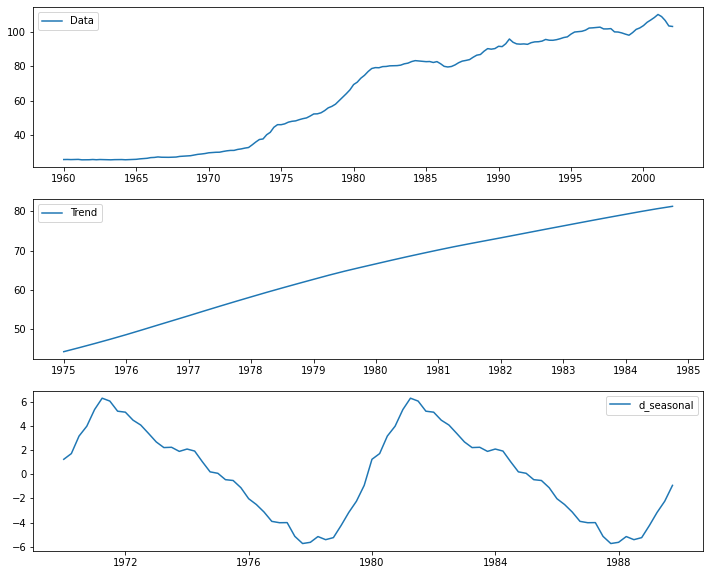

In [75]:
from statsmodels.tsa.seasonal import seasonal_decompose
temp=data_w.values

ts_comp=seasonal_decompose(data_w[40:120],period=40)

d_trend=ts_comp.trend
d_seasonal=ts_comp.seasonal
d_residual=ts_comp.resid


#plot the components
_,ax=plt.subplots(3,1,figsize=(12,10))

plt.subplot(311)
plt.plot(data_w,label='Data')
plt.legend()

plt.subplot(312)
plt.plot(d_trend,label='Trend')
plt.legend()

plt.subplot(313)
plt.plot(d_seasonal,label='d_seasonal')
plt.legend()

### checkstationarity

In [7]:
def checkstationarity(data):
    pvalue=adfuller(data)[1]
    print(pvalue)
    if pvalue < 0.05:
        msg='Data is stationary. Proceed to model building'
    else:
        msg='Data is not stationary. Diff. the data before model building'
    
    return msg

In [8]:
checkstationarity(data_w.ppi)

0.8264804014424036


'Data is not stationary. Diff. the data before model building'

In [9]:
def diff(data):
    global data_test_diff
    data_test_diff=data-data.shift(1)
    
    #plot
    _,ax=plt.subplots(figsize=(16,6))

    plt.subplot(121)
    plt.plot(data)
    plt.title('non_stationary data')

    plt.subplot(122)
    plt.plot(data_test_diff)
    plt.title('stationary data')
    
    #dataframe
    diffdf=pd.DataFrame({'actual':data,'differenced':data_test_diff})
    
    #drop nan value
    data_test_diff.dropna(inplace=True)
    
    return data_test_diff

yearqrt
1960-04-01    0.040001
1960-07-01   -0.070000
1960-10-01    0.029999
1961-01-01    0.090000
1961-04-01   -0.250000
                ...   
2001-01-01    1.790000
2001-04-01   -1.230000
2001-07-01   -2.300000
2001-10-01   -3.210000
2002-01-01   -0.290000
Name: ppi, Length: 168, dtype: float64

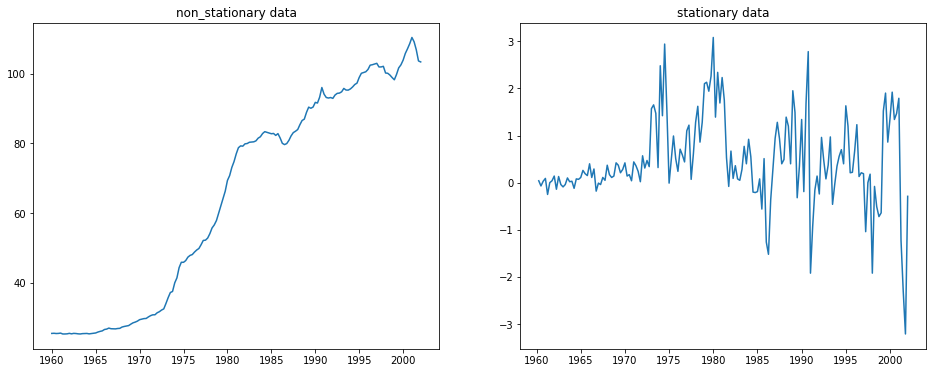

In [10]:
diff(data_w.ppi)

In [11]:
checkstationarity(data_test_diff)

0.0011801482847234536


'Data is stationary. Proceed to model building'

### split

In [12]:

#ss=int(len(data_test_diff)*0.7)
#traint=data_test_diff[:ss]
#testt=data_test_diff[ss:]
#print('train={},test={}'.format(len(traint),len(testt)))

In [13]:
ss=int(len(data_w)*0.7)
traint=data_w[:ss]
testt=data_w[ss:]
print('train={},test={}'.format(len(traint),len(testt)))

train=118,test=51


In [14]:
ss2=int(len(data)*0.7)
traint2=data[:ss2]
testt2=data[ss2:]
print('train={},test={}'.format(len(traint2),len(testt2)))

train=118,test=51


In [15]:
testt

,ppi
yearqrt,
1989-07-01,90.089996
1989-10-01,90.440002
1990-01-01,91.779999
1990-04-01,91.589996
1990-07-01,93.269997
1990-10-01,96.050003
1991-01-01,94.129997
1991-04-01,93.190002
1991-07-01,93.029999


In [16]:
#train=traint.ppi
#test=testt.ppi
#print('train={},test={}'.format(len(train),len(test)))

### ACF/PACF

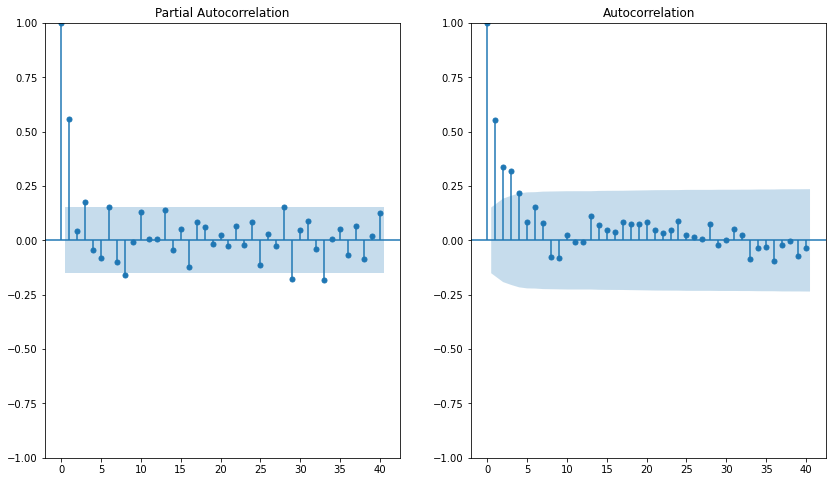

In [17]:
_,ax=plt.subplots(1,2,figsize=(14,8))

plot_pacf(data_test_diff,lags=40,ax=ax[0]);
plot_acf(data_test_diff,lags=40,ax=ax[1]);

In [18]:
len(testt)

51

In [19]:
rmse=[];name=[]

### ARMIA 

In [20]:
def fun(data,data1,p,d,q):
    
    train = pd.DataFrame(data)
    test = pd.DataFrame(data1)
    #print(test)
    m1=ARIMA(train,order=(p,d,q)).fit()
    global mse1
    
    
    f1=m1.forecast(len(test))
    #print(f1)
    actual=[]
    pred=[]
    for i in range(len(f1)):
        actual.append(test.ppi[i])
        pred.append(f1[i])
    df1=pd.DataFrame({'actual':actual,'predicted':pred})
    
    mse1=mean_squared_error(df1.actual,df1.predicted)
    
    return mse1

In [21]:
p=[0,1,2,3,4,5,6,7]
d=[1]
q=[0,1,2,3,4]
P=[];D=[];Q=[];RMSE=[]
for i in range(len(p)):
    for j in range(len(d)):
        for k in range(len(q)):
            
            fun(traint,testt,p=p[i],d=d[j],q=q[k])
            P.append(p[i]);D.append(d[j]);Q.append(q[k]);RMSE.append(round(np.sqrt(mse1),3))
            print('p='+str(p[i])+'  d='+str(d[j])+'  q='+str(q[k])+' Rmse={}'.format(round(np.sqrt(mse1),3)))
            

p=0  d=1  q=0 Rmse=9.952
p=0  d=1  q=1 Rmse=9.742
p=0  d=1  q=2 Rmse=9.106
p=0  d=1  q=3 Rmse=8.361
p=0  d=1  q=4 Rmse=8.248
p=1  d=1  q=0 Rmse=5.532
p=1  d=1  q=1 Rmse=6.925
p=1  d=1  q=2 Rmse=7.142
p=1  d=1  q=3 Rmse=6.861
p=1  d=1  q=4 Rmse=4.637
p=2  d=1  q=0 Rmse=3.988
p=2  d=1  q=1 Rmse=7.136
p=2  d=1  q=2 Rmse=7.046
p=2  d=1  q=3 Rmse=7.41
p=2  d=1  q=4 Rmse=4.008
p=3  d=1  q=0 Rmse=5.033
p=3  d=1  q=1 Rmse=6.983
p=3  d=1  q=2 Rmse=7.629
p=3  d=1  q=3 Rmse=7.704
p=3  d=1  q=4 Rmse=3.94
p=4  d=1  q=0 Rmse=7.557
p=4  d=1  q=1 Rmse=6.244
p=4  d=1  q=2 Rmse=6.99
p=4  d=1  q=3 Rmse=3.802
p=4  d=1  q=4 Rmse=4.708
p=5  d=1  q=0 Rmse=6.414
p=5  d=1  q=1 Rmse=6.534
p=5  d=1  q=2 Rmse=6.628
p=5  d=1  q=3 Rmse=7.334
p=5  d=1  q=4 Rmse=4.044
p=6  d=1  q=0 Rmse=6.892
p=6  d=1  q=1 Rmse=6.921
p=6  d=1  q=2 Rmse=9.257
p=6  d=1  q=3 Rmse=6.202
p=6  d=1  q=4 Rmse=5.058
p=7  d=1  q=0 Rmse=5.749
p=7  d=1  q=1 Rmse=5.114
p=7  d=1  q=2 Rmse=5.097
p=7  d=1  q=3 Rmse=5.51
p=7  d=1  q=4 Rmse=7.286


In [22]:
arima=pd.DataFrame(list(zip(P,D,Q,RMSE)),columns=['P','D','Q','RMSE']).sort_values(by='RMSE',ascending=True)[:1]
arima

,P,D,Q,RMSE
23,4,1,3,3.802


In [23]:
rmse.append(4.238)
name.append('arima')

In [24]:
def fun1(data,data1,p,d,q):
   
  
    train = pd.DataFrame(data)
    test = pd.DataFrame(data1)
    #print(test)
    #print(train.meantemp)
    m1=ARIMA(train,order=(p,d,q)).fit()
    summ=m1.summary()
    global aic1,bic1,mse1
    
    pvalue=sm.stats.acorr_ljungbox(m1.resid,lags=[1],return_df=True).lb_pvalue.values
    if pvalue < 0.05:
        print('not a good model')
    else:
        print('good model')
    aic1,bic1=m1.aic,m1.bic
    
    f1=m1.forecast(len(test))
    actual=[]
    pred=[]
    for i in range(len(f1)):
        actual.append(test.ppi[i])
        pred.append(f1[i])
    df1=pd.DataFrame({'actual':actual,'forecast':pred})
    #print(df1[:10])
    mse1=mean_squared_error(df1.actual,df1.forecast)
    
    df1.actual.plot(figsize=(10,5),legend=True)
    df1.forecast.plot(legend=True)
    plt.title('Actual and Forecasted(ARIMA) ')
    return summ,df1,pvalue

good model


(<class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:                    ppi   No. Observations:                  118
 Model:                 ARIMA(4, 1, 3)   Log Likelihood                 -93.973
 Date:                Tue, 11 Oct 2022   AIC                            203.947
 Time:                        08:49:15   BIC                            226.044
 Sample:                    01-01-1960   HQIC                           212.918
                          - 04-01-1989                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 ar.L1          1.0579      0.107      9.897      0.000       0.848       1.267
 ar.L2          0.4172      0.126      3.309      0.001       0.170   

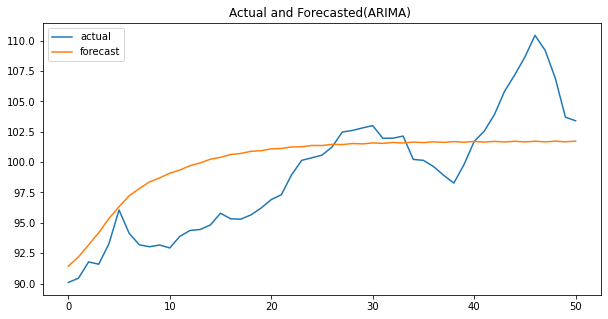

In [25]:
fun1(traint,testt,4,1,3)

## SARIMA

In [26]:
d_seasonal

yearqrt
1960-01-01    1.154745
1960-04-01    0.985744
1960-07-01    1.762746
1960-10-01    2.646038
1961-01-01    2.274578
                ...   
2001-01-01    2.274578
2001-04-01    2.037330
2001-07-01    1.609412
2001-10-01    1.003869
2002-01-01    0.702539
Name: seasonal, Length: 169, dtype: float64

In [27]:
checkstationarity(d_seasonal)

0.00807544728918941


'Data is stationary. Proceed to model building'

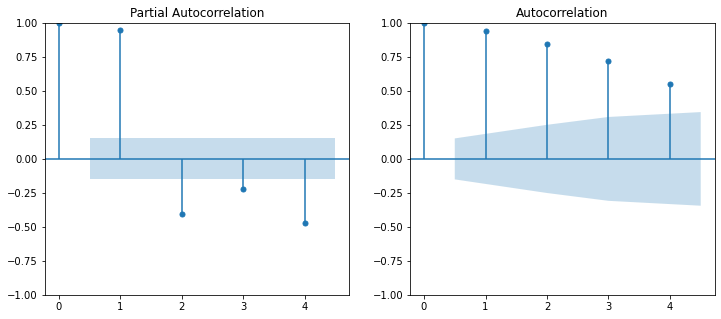

In [28]:
#for seasonal data
_,ax=plt.subplots(1,2,figsize=(12,5))
plot_pacf(d_seasonal,lags=4,ax=ax[0]);
plot_acf(d_seasonal,lags=4,ax=ax[1]);

In [31]:
#build sarima model
def fun1(data,data1,p,d,q,P,D,Q):
  
    
    #print(test)
    m1=SARIMAX(data,order=(p,d,q),seasonal_order=(P,D,Q,4)).fit()
    global mse1
    f1=m1.forecast(len(data1))
    mse1=mean_squared_error(data1,f1)
    
    
    return 

In [32]:
p=[0,1,2]
d=[1]
q=[0,1,2]
P=[0,1,2]
D=[0]
Q=[0,1,2]
ps=[];ds=[];qs=[];
RMSE=[];Ps=[];Ds=[];Qs=[];

for i in range(len(p)):
    for j in range(len(d)):
        for k in range(len(q)):
            for l in range(len(P)):
                for m in range(len(D)):
                    for n in range(len(Q)):
                        ps.append(p[i]);ds.append(d[j]);qs.append(q[k]);Ps.append(P[l]);Ds.append(D[m]);Qs.append(Q[n]);RMSE.append(round(np.sqrt(mse1),3))
                        fun1(traint,testt,p=p[i],d=d[j],q=q[k],P=P[l],D=D[m],Q=Q[n])
                        print('p='+str(p[i])+'  d='+str(d[j])+'  q='+str(q[k])+' P='+str(P[l])+'  D='+str(D[m])+'  Q='+str(Q[n])+'  Rmse={}'.format(round(np.sqrt(mse1),3)))
           

p=0  d=1  q=0 P=0  D=0  Q=0  Rmse=9.952
p=0  d=1  q=0 P=0  D=0  Q=1  Rmse=7.924
p=0  d=1  q=0 P=0  D=0  Q=2  Rmse=7.167
p=0  d=1  q=0 P=1  D=0  Q=0  Rmse=3.386
p=0  d=1  q=0 P=1  D=0  Q=1  Rmse=3.573
p=0  d=1  q=0 P=1  D=0  Q=2  Rmse=4.478
p=0  d=1  q=0 P=2  D=0  Q=0  Rmse=3.508
p=0  d=1  q=0 P=2  D=0  Q=1  Rmse=7.313
p=0  d=1  q=0 P=2  D=0  Q=2  Rmse=6.351
p=0  d=1  q=1 P=0  D=0  Q=0  Rmse=9.742
p=0  d=1  q=1 P=0  D=0  Q=1  Rmse=8.236
p=0  d=1  q=1 P=0  D=0  Q=2  Rmse=7.703
p=0  d=1  q=1 P=1  D=0  Q=0  Rmse=5.139
p=0  d=1  q=1 P=1  D=0  Q=1  Rmse=4.597
p=0  d=1  q=1 P=1  D=0  Q=2  Rmse=4.219
p=0  d=1  q=1 P=2  D=0  Q=0  Rmse=4.736
p=0  d=1  q=1 P=2  D=0  Q=1  Rmse=6.056
p=0  d=1  q=1 P=2  D=0  Q=2  Rmse=5.804
p=0  d=1  q=2 P=0  D=0  Q=0  Rmse=9.106
p=0  d=1  q=2 P=0  D=0  Q=1  Rmse=7.514
p=0  d=1  q=2 P=0  D=0  Q=2  Rmse=7.294
p=0  d=1  q=2 P=1  D=0  Q=0  Rmse=5.592
p=0  d=1  q=2 P=1  D=0  Q=1  Rmse=4.358
p=0  d=1  q=2 P=1  D=0  Q=2  Rmse=5.302
p=0  d=1  q=2 P=2  D=0  Q=0  Rmse=4.996


In [33]:
sarima=pd.DataFrame(list(zip(ps,ds,qs,Ps,Ds,Qs,RMSE)),columns=['p','d','q','P','D','Q','RMSE'])
sarima.sort_values(by=['RMSE'])[:1]

,p,d,q,P,D,Q,RMSE
4,0,1,0,1,0,1,3.386


In [ ]:
rmse.append(3.889)
name.append('sarima')

In [34]:
sm1=SARIMAX(traint,order=(0,1,0),seasonal_order=(1,0,1,4)).fit()


In [35]:
f1=sm1.forecast(len(testt))
f1

1989-07-01     91.217117
1989-10-01     91.483927
1990-01-01     92.828612
1990-04-01     93.825988
1990-07-01     94.352941
1990-10-01     94.527137
1991-01-01     95.405063
1991-04-01     96.056236
1991-07-01     96.400276
1991-10-01     96.514006
1992-01-01     97.087192
1992-04-01     97.512334
1992-07-01     97.736952
1992-10-01     97.811205
1993-01-01     98.185430
1993-04-01     98.462999
1993-07-01     98.609650
1993-10-01     98.658129
1994-01-01     98.902455
1994-04-01     99.083676
1994-07-01     99.179422
1994-10-01     99.211073
1995-01-01     99.370590
1995-04-01     99.488907
1995-07-01     99.551418
1995-10-01     99.572082
1996-01-01     99.676229
1996-04-01     99.753476
1996-07-01     99.794289
1996-10-01     99.807780
1997-01-01     99.875776
1997-04-01     99.926210
1997-07-01     99.952856
1997-10-01     99.961664
1998-01-01    100.006058
1998-04-01    100.038985
1998-07-01    100.056382
1998-10-01    100.062133
1999-01-01    100.091117
1999-04-01    100.112615


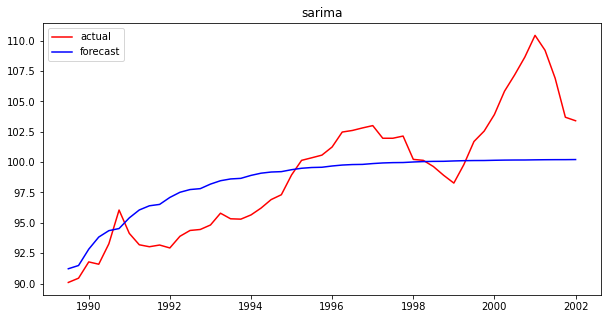

In [36]:
plt.figure(figsize=(10,5))
plt.plot(testt, 'r', label = 'actual')
plt.plot(f1, 'b', label='forecast')
plt.title('sarima')
plt.legend()



## SARIMAX

In [47]:
#import seaborn as sns
#fig=plt.figure(figsize=(10,10))
#sns.heatmap(data.corr(), annot = True)

In [41]:
#build sarimax model
def fun2(data,data1,p,d,q,P,D,Q):
  
    exog_train=traint2[['m3','cpi','gdp','m1nsa','ddnsa','lnppi']]
    exog_test=testt2[['m3','cpi','gdp','m1nsa','ddnsa','lnppi']]
    #print(test)
    m1=SARIMAX(data,order=(p,d,q),seasonal_order=(P,D,Q,4),exog=exog_train.values).fit()
    global mse1
    f1=m1.forecast(len(data1),exog=exog_test.values)
    mse1=mean_squared_error(data1,f1)
    
    
    return 

In [42]:
p=[0,1]
d=[1]
q=[0,1,2]
P=[0,1,2]
D=[0]
Q=[0,1]
px=[];dx=[];qx=[];
RMSE=[];Px=[];Dx=[];Qx=[];

for i in range(len(p)):
    for j in range(len(d)):
        for k in range(len(q)):
            for l in range(len(P)):
                for m in range(len(D)):
                    for n in range(len(Q)):
                        px.append(p[i]);dx.append(d[j]);qx.append(q[k]);Px.append(P[l]);Dx.append(D[m]);Qx.append(Q[n]);RMSE.append(round(np.sqrt(mse1),3))
                        fun2(traint2.ppi,testt2.ppi,p=p[i],d=d[j],q=q[k],P=P[l],D=D[m],Q=Q[n])

In [43]:
sarimax=pd.DataFrame(list(zip(px,dx,qx,Px,Dx,Qx,RMSE)),columns=['p','d','q','P','D','Q','RMSE'])
sarimax.sort_values(by=['RMSE'])[:1]

,p,d,q,P,D,Q,RMSE
1,0,1,0,0,0,1,1.815


In [44]:
rmse.append(1.815)
name.append('sarimax')

In [50]:
exog_train=traint2[['m3','cpi','gdp','m1nsa','ddnsa','lnppi']]
exog_test=testt2[['m3','cpi','gdp','m1nsa','ddnsa','lnppi']]

sm2=SARIMAX(traint2.ppi,order=(0,1,0),seasonal_order=(0,0,1,4),exog=exog_train.values).fit()

In [61]:
f2=sm2.forecast(len(testt2),exog=exog_test.values)
f2.head(15)

1989-07-01    90.608427
1989-10-01    90.963329
1990-01-01    92.391333
1990-04-01    92.753100
1990-07-01    93.989805
1990-10-01    95.690136
1991-01-01    95.422032
1991-04-01    95.127177
1991-07-01    95.272486
1991-10-01    95.443438
1992-01-01    95.517673
1992-04-01    96.066996
1992-07-01    96.456223
1992-10-01    96.490509
1993-01-01    97.043505
Freq: QS-OCT, Name: predicted_mean, dtype: float64

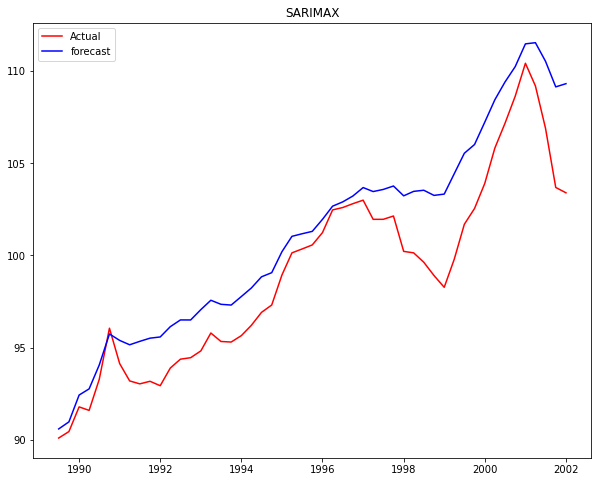

In [53]:
plt.figure(figsize=(10,8))
plt.plot(testt2.ppi, 'r', label = 'Actual')
plt.plot(f2, 'b', label='forecast')
plt.title('SARIMAX')
plt.legend()


In [58]:
sm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                 ppi   No. Observations:                  117
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 4)   Log Likelihood                  10.939
Date:                             Tue, 11 Oct 2022   AIC                             -3.879
Time:                                     12:31:48   BIC                             20.903
Sample:                                 04-01-1960   HQIC                             6.181
                                      - 04-01-1989                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -1.34e-05      0.000     -0.051      0.959      -0.001       0.001
x2             0.3750      0.082      4.549      0.000       0.213       0.537
x3            -0.0004      0.000     -0.714      0.475      -0.001       0.001
x4             0.0019      0.006      0.316      0.752      -0.010       0.013
x5            -0.0136      0.011     -1.232      0.218      -0.035       0.008
x6            39.1263      1.715     22.817      0.000      35.765      42.487
x7             0.0331      0.044      0.751      0.453      -0.053       0.119
ma.S.L4        0.3158      0.090      3.508      0.000       0.139       0.492
sigma2         0.0483      0.006      8.272      0.000       0.037       0.060
===================================================================================
Ljung-Box (L1) (Q):                  10.05   Jarque-Bera (JB):                19.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.78   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
pvalue=sm.stats.acorr_ljungbox(sm2.resid,lags=[1],return_df=True).lb_pvalue.values
if pvalue < 0.05:
    print('not a good model')
else:
    print('good model')

good model


In [64]:
actual=[]
pred=[]
for i in range(len(f2)):
    actual.append(testt2.ppi[i])
    pred.append(f2[i])
pd.DataFrame({'actual':actual,'forecast':pred}).head(15)

,actual,forecast
0,90.089996,90.608427
1,90.440002,90.963329
2,91.779999,92.391333
3,91.589996,92.753100
4,93.269997,93.989805
5,96.050003,95.690136
6,94.129997,95.422032
7,93.190002,95.127177
8,93.029999,95.272486
9,93.169998,95.443438


In [54]:
traint3=traint2.copy()
testt3=testt2.copy()

In [55]:
traint3.dropna(inplace=True)
testt3.dropna(inplace=True)

In [56]:
exog_train=traint3[['m3','cpi','gdp','m1nsa','ddnsa','lnppi','lppi']]
exog_test=testt3[['m3','cpi','gdp','m1nsa','ddnsa','lnppi','lppi']]

sm2=SARIMAX(traint3.ppi,order=(0,1,0),seasonal_order=(0,0,1,4),exog=exog_train.values).fit()

In [ ]:
f2=sm2.forecast(len(testt3),exog=exog_test.values)
f2.head()

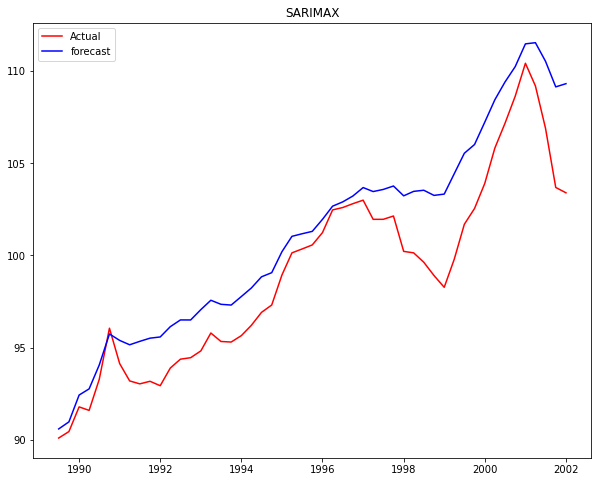

In [57]:
plt.figure(figsize=(10,8))
plt.plot(testt3.ppi, 'r', label = 'Actual')
plt.plot(f2, 'b', label='forecast')
plt.title('SARIMAX')
plt.legend()



,actual,forecast
0,90.089996,90.608427
1,90.440002,90.963329
2,91.779999,92.391333
3,91.589996,92.753100
4,93.269997,93.989805
5,96.050003,95.690136
6,94.129997,95.422032
7,93.190002,95.127177
8,93.029999,95.272486
9,93.169998,95.443438


In [ ]:
mse2 = mean_squared_error(testt3.ppi,f2).round(10)
print('RMSE: ' + str(np.sqrt(mse2)))

In [ ]:
final_s=pd.DataFrame(list(zip(name,rmse)),columns=['Algorithm','rmse']).set_index('Algorithm').sort_values(by='rmse',ascending=True)


In [ ]:
final_s

In [ ]:
final_s.plot(kind='bar',figsize=(8,6))
plt.xticks(rotation = 0);
plt.title('RMSE');

In [ ]:
exog_train=traint3[['m3','cpi','gdp','m1nsa','ddnsa','lnppi','dppi','dlnppi','lppi']]
exog_test=testt3[['m3','cpi','gdp','m1nsa','ddnsa','lnppi','dppi','dlnppi','lppi']]

sm2=SARIMAX(traint3.ppi,order=(0,1,0),seasonal_order=(0,0,1,40),exog=exog_train.values).fit()

In [ ]:
f2=sm2.forecast(len(testt3),exog=exog_test.values)
f2.head()

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(testt3.ppi, 'r', label = 'Actual')
plt.plot(f2, 'b', label='forecast')
plt.title('SARIMAX')
plt.legend()



In [ ]:
mse2 = mean_squared_error(testt3.ppi,f2).round(10)
print('RMSE: ' + str(np.sqrt(mse2)))

In [ ]:
rmse

In [ ]:
name

In [ ]:
final_s